
---

<big><big><big><big><big><big><big><big><big>Sieci neuronowe</big></big></big></big></big></big></big></big></big>

---


---

<id=tocheading><big><big><big><big><big>Spis treści</big></big></big></big></big>
<div id="toc"></div>

---

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set(font_scale=2.5)

In [3]:
# -*- coding: utf-8 -*-
"""
Demo of unicode support in text and labels.
"""
from __future__ import unicode_literals
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file, load_boston, load_breast_cancer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [4]:
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples, completeness_contamination

# Ograniczenia modeli
* modele liniowe mają ograniczenia z powodu klątwy wymiarowości
* niewystarczające są __ustalone__ funkcje bazowe
  * zły wybór może powodować overfitting  
  * trzeba __adaptować__ funkcje do konkretnych danych
  * ograniczyć liczbę funkcji bazowych

* alternatywne podejście
  * ustalić funkcje bazowe z góry - niewielką liczbę, zwykle __jedną__
  * niech funkcje __adaptują__ się w trakcie nauki
  * model jest zwykle znacznie mniejszy
  * funkcja ___likelihood_ nie będzie już wypukła__
    * konieczność przeglądnięcia większej liczby modeli

# Neuron biologiczny

  <img src="../mum_figures/neuron.png" width="100%"/>
  
  <img src="../mum_figures/synapse.jpg" width="100%"/>

![Potential](file:///Users/igorpodolak/Dropbox/mum_figures/potential.gif)

![Awesome cat gif](http://media.giphy.com/media/7z2oyDXIMEs8w/giphy.gif)

![Potential](http://github.com/gmum/ml2017/wyklady/mum_figures/potential.gif)

<img src="../mum_figures/potential.jpg" width="100%"/>

# Sieci z propagacją sygnału (feed-forward)
<img src="../mum_figures/mlp.png" width="100%"/>
* funkcje bazowe modelu
  * muszą __zależeć__ od parametrów
  * parametry powinny się zmieniać w trakcie uczenia
  * współczynniki $w_j$ także są modyfikowalne
* $M$ liniowych kombinacji wejść $$v_j=\sum_i^Dw_{ji}x_i+w_{j0}$$
gdzie $M$ jest liczbą __"neuronów"__ w pierwszej __warstwie__ modelu
  * $w_{j0}$ to __bias__ $j$-tego neuronu
  * $v_j$ to __aktywacje__
  * teraz użyta jest __funkcja aktywacji__ $\varphi()$ (różniczkowalna) $$z_j=\varphi(v_j)$$
    * funkcje aktywacji są zwykle funkcjami sigmoidalnymi, np.
    $$\frac{1}{1+\exp({-v})}, \tanh(-v)$$
  * neurony w warstwach, które nie są ani wejściową ani ukrytą nazywamy __ukrytymi__
  
  
* obliczenia powtarzają się w kolejnych warstwach
* końcowa wartość jest jako, dla sieci z jedną warstwą ukrytą
$$y_k(x)=\sigma\left(\sum_k^Mw_kj\sigma\left(\sum_i^Dw_{ji}x_i+w_{j0}\right)+w_{k0}\right)$$
  * jeśli problem regresji, to końcowa funkcja aktywacji jest identycznością
  * sieć neuronowa jest __nieliniową__ funkcją wejść $x_i$
    * wartość bias włączamy do wektora $w$ __rozszerzając__ wejście o $x_0=1$

* sygnał jest przesyłany do przodu, stąd nazwa
* sieć wielowarstwowa nazywana __wielowarstwowym perceptronem__
  * zaproponowany przez McCullocha i Pittsa __perceptron__ 
    * wykorzystywał __progową__ funkcję aktywacji (f. Heaviside'a)
    * nie zawierał warstw ukrytych

* sieć z __liniowymi__ f. aktywacji w w. ukrytych jest redukowalna do sieci __bez__ warstw ukrytych
* sieci warstwowe można uogólnić przez dodanie __połączeń skrótowych__

* nazewnictwo
  * istnieje wiele zwyczajów: sieć na rysunku może być nazywana 
    * 4-warstwową (bo liczba wszystkich warstw neuronów), 
    * 3-warstwową (bo liczba warstw adaptowalnych parametrów), 
    * 2-warstwową (bo liczba warstw ukrytych)
  * Bishop preferuje drugie podejście
  * jasne będzie "sieć z dwoma warstwami ukrytymi"

# Sieci neuronowe jako uniwersalny aproksymator
> Sieć neuronowa z jedną warstwą ukrytą neuronów z nieliniowymi ciągłymi monotonicznie rosnącymi funkcjami aktywacji może dowolnie dokładnie dla $\epsilon>0$ aproksymować dowolną funkcję ciągła zdefiniowaną na hiperkostce $[0, 1]^m$.

> Twierdzenie jest o _istnieniu_ takiej sieci, a nie mówi jak znaleźć odpowiednią liczbę neuronów.

## Funkcja kosztu: regresja
* niech przewidywana pojedyncza zmienna $t$ ma rozkład normalny zależny od wejściowego $x$ $$p(t\mid x)=\mathcal{N}(t\mid y(x, w), \sigma)$$ gdzie
  * $y(x, w)$ jest wyjściem sieci
  * $\sigma$ jest wariancją
* $X=\{x_1,x_2,\dots,x_N\}$ zbiorem $N$ __niezależnych__ przykładów
* dla wartości spodziewanych (target) $\{t_1,\dots,t_N\}$ można utworzyć __likelihood__ 
$$p(t\mid X,w,\sigma)=\prod_{n=1}^Np(t_n\mid x_n,w,\sigma)$$

* biorąc __ujemny logarytm__ dostajemy __log-likelihood__
$$\frac{1}{2\sigma}\sum_{n=1}^N\left(y(x_n,w)-t_n\right)^2+\frac{N}{2}\ln\sigma +\frac{N}{2}\ln(2\pi)$$
* maksymalizacja likelihood jest równoważna __minimalizacji__ log-likelihood, co jest identyczne z minimalizacją funkcji kosztu
$$E(w)=\frac{1}{2}\sum_{n=1}^N\left(y(x_n,w)-t_n\right)^2$$
  * nieliniowość funkcji $y(x,w)$ powoduje, że $E(w)$ __nie jest wypukła__
  * funkcja kosztu będzie miała __minima lokalne__
  * po znalezieniu wektora $w^\ast$ można znaleźć $\sigma$ jako
  $$\sigma=\frac{1}{N}\sum_{n=1}^N\left(y(x_n,w^\ast)-t_n\right)^2$$



## Funkcja kosztu: klasyfikacja
* przypadek klasyfikacji binarnej
  * pojedynczy neuron wyjsciowy z $\sigma()$ __logistyczną__
  $$y=\sigma(v)=\frac{1}{1+\exp(-v)}$$
  * niech $t=1$ jeśli $x\in C_1$; $t=2$ jeśli $x\in C_2$
  * niech $y(x,w)$ będzie __prawdopodobieństwem__, że $x\in C_1$
  * $1-y(x,w)$ prawdopodobieństwem, że $x\in C_2$
  
* rozkład warunkowy wyjść rozkładem Bernoulliego
$$p(t\mid x)=y(x,w)^t\left(1-y(x,w)\right)^{1-t}$$

* dla zbioru wszystkich przykładów $X$ mamy likelihood
$$p(t\mid X,w)=\prod_ny(x_n,w)^t_n\left(1-y(x_n,w)\right)^{1-t_n}$$
* znowu ujemny logarytm daje log-likelihood i funkcję kosztu
$$E(w)=-\sum_{n=1}^N\left[t_n\ln\,y_n+(1-t_n)\ln\,(1-y_n)\right]$$
nazywaną __entropią krzyżową__
  
  * dla klasyfikacji użycie entropii krzyżowej daje lepsze wyniki niż użycie funkcji kwadratowej kosztu
* dla problemu wieloklasowego $t\in\{C_1,\dots,C_K\}$ mamy
$$E(w)=-\sum_{n=1}^N\sum_{k=1}^K\left[t_{nk}\ln\,y_k(x_n,w)+(1-t_{nk})\ln\,(1-y_k(x_n,w))\right]$$
* dla klasyfikacji wieloklasowej mamy
  $$y_k(x,w)=p(t_k=1\mid x)$$
  * to skraca wyrażenie entropii krzyżowej do
  $$E(w)=-\sum_{n=1}^N\sum_{k=1}^Kt_n\ln\,y_k(x_n,w)$$
  * dla problemu wieloklasowego aktywacją wyjściową jest funkcja softmax
  $$y_k(x,w)=\frac{\exp(v_k(x,w))}{\sum_{j=1}^K\exp(v_j(x,w))}$$

## Cechy
* podstawowa różnica do modeli liniowych: sieć neuronowa __mapuje przestrzeń wejściową do przestrzeni ukrytej gdzie znajduje rozwiązanie__
  * __nieliniowe__ rzutowanie do przestrzeni ukrytej zwiększa prawdopodobieństwa liniowej separowalności

* aktywacje warstw ukrytych dla danego wejścia nazywamy cechami
  * w modelach każda przynależność do klasy jest rozwiązywana jako __całkowicie osobny__ problem
  * w sieciach podproblemy przynależności do klas __dzielą cechy__

# Uczenie sieci warstwowych neuronowych
* zadaniem jest minimalizacja $E(w)$
* drobna zmiana $w$ powoduje __presunięcie__ się po powierzchni funkcji kosztu
  * dualność: każde rozwiązanie odpowiada punktowi w przestrzeni wag
* przestrzeń rozwiązań jest zwykle bardzo wysoko wymiarowa
  * istnieje wiele punktów o $\nabla{}E(w)\simeq0$
  * to minima/maksima lokalne/globalne, punkty siodłowe

## Lokalna aproksymacja kwadratowa
* rozwinięcie funkcji kosztu w szereg Taylora
$$E(w)\simeq E(w_0)+(w-w_0)g+\frac{1}{2}(w-w_0)H(w-w_0)$$
gdzie 
$$\begin{align}
g=&\frac{\partial E}{\partial w}\\
H=&\frac{\partial^2 E}{\partial w_i\,\partial w_j}
\end{align}$$

* stąd
$$\nabla E\simeq g+H(w-w_0)$$

## Uczenie gradientowe
* uczenie małymi krokami
$$w(t+1)=w(t)-\eta\nabla E(w(t))$$
gdzie $\eta$ jest __współczynnikiem nauczania__

## Tryby uczenia gradientowego

* to metoda __epoka po epoce__ (ang. batch)
  * każdy krok poprawy wymaga wielu obliczeń
  * każda propagacja wprzód używa starych wag
  * wiele przykładów dzieli wspólne cechy, stąd utrata wielu możliwych informacji
  * uczenie po epokach może powodować krążenie w przestrzeni rozwiązań
  * usprawnienie: metoda gradientów sprzężonych zapewniająca poprawy
    * każda poprawa jest ortogonalna do poprzednich
    * teoretycznie roziązanie po co najwyżej tylu krokach ile jest wag

* epoka __przykład po przykładzie__ (ang. stochastic gradient descent)
$$E(w)=\sum_nE_n(w)$$
  * poprawa po każdym przykładzie
  $$w(t+1)=w(t)-\eta\nabla E_n(w(t))$$
  * uwzględnia wiedzę z innych przykładów od razu
  * pozwala na łatwiejsze omijania minimów lokalnych
 
* __mini batch__
  * uczenie małymi grupami przykładów
  * najbardziej efektywne

# Wsteczna propagacja błędów
* sieci przechodziły przez wzloty i upadki
* zapowiadano (Minsky i Papert w _Perceptron_) śmierć ze względu na __niemożność__ uczenia sieci z warstwami ukrytymi
* problem z liczeniem gradientu dla warstw ukrytych
* algorytm wstecznej propagacji zaproponowany przez Werbosa


* w trakcie uczenia obliczana jest duża liczba pochodnych funkcji kosztu __względem__ wag
* wsteczna propagacja jest __efektywnym__ machenizmem ich obliczania
  * pochodne (błędy) są przesyłane wstecz w sieci
* drugim elementem jest obliczenie i modyfikacja wartości wag

* schemat może być użyty do szerokiego wachlarza architektur sieci



Funkcja kosztu $$E(w)=\sum_{n=1}^NE_n(w)$$
<img src="../mum_figures/backpropagation.png" width="70%"/>
1. neurony wyjściowe w modelu __liniowym__
  * $y_k=\sum_kw_{ki}x_i$ i funkcją kosztu 
  $$E_n=\frac{1}{2}\sum_k(y_{nk}-t_{nk})^2$$
  * uczenie polega na __modyfikacji__ wag w celu __minimalizacji__ kosztu
  
  $$\frac{\partial E_n}{\partial w_{kj}}=(y_{nj}-t_{nj})x_i$$
  co jest uczeniem __przez poprawianie błędu__
2. modele wielowarstwowe
  * aktywacja neuronu w warstwie to
  
  $$z_j=\varphi(v_j)=\varphi\left(\sum_iw_{ji}z_i\right)$$
  z nieliniową funkcją aktywacji $\varphi(\cdot)$
  * koszt jest zależny od wag __tylko__ przez sumę ważoną $v_j$
  
  $$\frac{\partial E_n}{\partial w_{ji}}=\frac{\partial E_n}{\partial v_j}\frac{\partial v_j}{\partial w_{ji}}$$
  <img src="../mum_figures/backpropagation.png" width="80%"/>
  * wprowadzamy oznaczenie __delta__
  
  $$\delta_j\equiv\frac{\partial E_n}{\partial v_j}$$
  odpowiadające lokalnemu wpływowi na całkowity błąd
  
  $$\begin{align}
  \frac{\partial E_n}{\partial w_{ji}}&=\frac{\partial E_n}{\partial v_j}\frac{\partial v_j}{\partial w_{ji}}\\
  &=\delta_j\frac{\partial v_j}{\partial w_{ji}}\\
  &=\delta_jz_i
  \end{align}$$
    * dla neuronów (liniowych) __wyjściowych__ mamy
    
    $$\delta_k=\frac{\partial E_n}{\partial v_k}=y_k-t_k$$
    * dla neuronów __ukrytych__ (tu w warstwie __poprzedzającej__ wyjściową)
    
    $$\begin{align}
    \delta_j&=\frac{\partial E_n}{\partial v_j}\\
    &=\sum_k\frac{\partial E_n}{\partial v_k}\frac{\partial v_k}{\partial v_j}\\
    &=\sum_k\delta_k\frac{\partial v_k}{\partial v_j}\\    &\hskip{4em}\text{gdzie}\hskip{1em}v_k=\sum_jw_{kj}z_j=\sum_jw_{kj}\varphi(v_j)\\
    &=\varphi'(v_j)\sum_kw_{kj}\delta_k
    \end{align}$$
    <img src="../mum_figures/backpropagation.png" width="100%"/>
      * wartości $\delta_k$ zostały już obliczone dla wartwy __późniejszej__ w modelu sieci
      * $\delta_j$ odpowiadają __wpływowi $j$-tego neuronu na błędy w późniejszych warstwach__, czyli __loklanemu błędowi $j$-tego ukrytego neuronu__
      * stąd __wsteczna propagacja błędów__

### Funkcje aktywacji
* zwykle __sigmoidalne__
  * wprowadzają __nieliniowość__
  * __logistyczna__ $$\sigma(v)=\frac{1}{1+exp(-v)}$$
    * pochodna prosta obliczeniowo $$\sigma'(v)=\sigma(v)(1-\sigma(v))$$
  * __tangens hiperboliczny__
    * aktywacja na $(-1, 1)$
    * preferowany dla niskich warstw
      * pozwala by wymusić średnią aktywacji $0$ co zwykle przyspiesza uczenie
  * gradient dla wysokich wartości bezwzględnych __zanika__
    * tzw. __vanishing gradient problem__
    * uczenie zanika mimo błędu
* problem zanikającego gradientu utrudnia uczenie sieci o wielu warstwach ukrytych
  * propozycja aktywacji __rectified linear__ $$\varphi(v)=\max(0, v)$$
    * gradient nie zanika
    * możliwe modyfikacje

### Co się dzieje w warstwie ukrytej (3 różne klasy)

* aktywacje oczekiwne
<img src="../mum_figures/cl3-in.png" width="50%"/>
* aktywacje uzyskane
<img src="../mum_figures/cl3-out.png" width="50%"/>
* aktywacje warstwy ukrytej (kolory według klasy uzyskanej)
<img src="../mum_figures/cl3-hid.png" width="50%"/>
* błąd aktywacji
<img src="../mum_figures/cl3-err.png" width="50%"/>

### Co się dzieje w warstwie ukrytej (4 różne klasy)

* aktywacje oczekiwne
<img src="../mum_figures/cl4-in.png" width="50%"/>
* aktywacje uzyskane
<img src="../mum_figures/cl4-out.png" width="50%"/>
* aktywacje warstwy ukrytej (kolory według klasy uzyskanej)
<img src="../mum_figures/cl4-hid.png" width="50%"/>
* błąd aktywacji
<img src="../mum_figures/cl4-err.png" width="50%"/>

## Czy wsteczna propagacja jest efektywna obliczeniowo?
* liczba obliczeń przy obliczaniu aktywacji jest proporcjonalna do liczby wag
  * wag jest __znacznie__ więcej niż neuronów
* obliczenia dla funkcji kosztu też są rzędu liczby wag

* numeryczne obliczanie pochodnych 

$$\frac{\partial E}{\partial w}=\frac{E(w+\epsilon)-E(w)}{\epsilon}+O(\epsilon)$$
lub

$$\frac{\partial E}{\partial w}=\frac{E(w+\epsilon)-E(w-\epsilon)}{2\epsilon}+O(\epsilon^2)$$
ma wyższą złożoność $O(w^2)$

## Obliczenia drugiego rządu
* macierz drugich pochodnych

$$\frac{\partial^2 E}{\partial w_j \partial w_k}$$
* macierz Hesjanu $$H=\nabla\nabla E$$
  * pozwala w optymalizacju brać pod uwagę __krzywiznę__ powierzchni błędu
    * gradient tylko kierunek zmian
  * odwrotność H umożliwia znalezienie nieistotnych wag w sieci (pruning)
  * szybkie douczanie po zmianie przykładów
    * niewielka zmiana położenia minimum
* wyższa złożoność $O(W^2)$

# Regularyzacja
* zwykle bardzo duża liczba parametrów (wag)
* konieczność długich testów dla znalezienia optymalnych parametrów
  * liczba neuronów, wartości wag, etc.

1. __weight decay__ (__L2__)

$$\overline{E}(w)=E(w)+\frac{1}{2}w^Tw$$

2. __L1__
$$\overline{E}(w)=E(w)+\|w\|_1$$

2. problemy z liniową transformację
  * skalowanie wejść jest __niespójne__ z prostą regularyzacją __ weight decay__
    * translacja (skalowanie) wejść (lub wyjść) da nierównoważną (przez liniowe przekształcenie) sieć przy uczeniu z weight decay
    * translacje inaczej wpływają na różne warstwy sieci
  * osobny czynnik egularyzacyjny dla osobnych warstw sieci
  
  $$\frac{\lambda_1}{2}\sum_{w\in W_1}w^2+\frac{\lambda_2}{2}\sum_{w\in W_2}w^2$$
  
3. wczesne zatrzymywanie
  * błąd na zbiorze uczącym maleje w trakcie uczenia
  * błąd na zbiorze __walidującym__ zaczyna rosnąć
    * jest to znak rozpoczęcia zbytniego dopasowania
  <img src="../mum_figures/generalization.png" width="120%"/>



## Alternatywy
* wsteczna propagacja _per se_ jest powolna
* blisko minimum może wpaść w oscylacje
* problemy przy niskim spadku
* metoda __momentum__

$$w(t+1)=w(t)-\eta\nabla E(t) -\alpha\Delta(w(t-1))$$
  * szereg usprawnień, np. algorytm Adam
* metody adaptacynego kroku
  * atrybuty wejsciowe nie mają równego wpływu na rozwiązanie
  * osobne parametry uczenia dla każdego z nich
  * algorytm delta-delta
* problemy z _płaską_ powierzchnią błędu
  * metoda __resilient backpropagation__
  
  $$\Delta w_{ji}(t+1)=\begin{cases}
  -\eta_{ji}sgn(\nabla_{ji} E(t))&\text{jeśli}\;\;\nabla_{ji}E(t)\nabla_{ji}E(t-1)\geq0\\
  0; \nabla_{ji}E(t)=0&\text{w przeciwnym przypadku}
  \end{cases}$$
  * parametr też potrzebuje być modyfikowany
  $$\eta_{ji}(t+1)=\begin{cases}
  min(u*\eta_{ji}, \eta_{max})&\nabla_{ji}E(t)\nabla_{ji}E(t-1)>0\\
  max(d*\eta_{ji}, \eta_{min})&\nabla_{ji}E(t)\nabla_{ji}E(t-1)<0\\
  \eta_{ji}&\text{wpp}
  \end{cases}$$
  dla $u>1$ i $d<1$, np. $u=1.05$ i $d=0.7$
    * podwyższany jeśli kolejne gradienty w tym samym kierunku
    * zmniejszany jeśli w przeciwnym
* bardzo efektywne podejście dla algorytmów klasyfikacji

* wiele obecnych algorytmów, np. Adam, współdzielą wiele cech

# Sieci konwolucyjne
* wiele cech jest dzielonych
* mogą wystąpić w __różnych__ częściach wejścia (obrazy)
* konieczna niezależność (chociaż nawet niewielka) na translację/skalowanie
  1. utworzyć bardzo duży zbiór uczący wszelkich możliwości
  
  
  
* lokalne cechy
  * niewielkie obszary wejściowe
  * filtry/konwolucje
  * struktura kratki
    * jedno-wymiarowe szeregi czasowe
    * dwu-wymiarowe obrazy
    * czasem trój-wymiarowa (obrazy medyczne)
* dzielenie wag
  * te same cechy w różnych obszarach
  * ograniczenie liczby rzeczywistych parametrów
* subsampling
  * odporność na translacje
* hierarchiczność
  * wykrywanie prostych cech i ich składanie
  
  
* model Neocognitron Fukushimy (1980)
  <img src="../mum_figures/neocognitron.png" width="120%"/>



### AlexNet (ImageNet, KSH) (Krizhevsky, Sutskeyer, Hinton)
<img src="../mum_figures/alexnet.jpg" width="120%"/>

<img src="../mum_figures/conv-images.png" width="120%"/>

## Konwolucje
1. jedno-wymiarowe
  * pomiar danych w których ostatnie odczyty są bardziej znaczące (szeregi czasowe)
  
  $$s(t)=\int x(a)w(t-a)da$$
  jest __konwolucją__ gdzie $a$ jest wiekiem pomiaru, zwykle $s(t)=(x\ast w)(t)$
    * $x$ to __wejście__
    * $w$ __jądro__ (kernel)
    * wyjście jest __cechą__
  * pomiary są dyskretne
  
  $$s(t)=\sum_{a=-\infty}^\infty x(a)w(t-a)$$
    * wartości jądra są równe $0$ poza skończoną liczbą pozycji
2. dwu-wymiarowe
  * filtr na obrazie $I$
  
  $$\begin{align}
  s(i,j)&=(I\ast K)(i, j)=\sum_m\sum_n I(m,n)K(i-m,j-n)\\
  &=(K\ast I)(i, j)=\sum_m\sum_n I(i-m,j-n)K(m,n)
  \end{align}$$
  * zwykle implementowane jest __korelacja krzyżowa__, równoważna
  
  $$s(i,j)=(K\ast I)(i, j)=\sum_m\sum_n I(i+m,j+n)K(m,n)$$

### Cechy
* rzadkie połączenia, rzadkie wagi
  * kernele znacznie mniejsze od obrazu
    * efektywność obliczeniowa
  * pojedyncze wejścia wpływają tylko na niewiele wyjść
  * na pojedynczą konwoulcję (wyjście) wpływa niewiele wejść
* lokalność cech
  * konwolucje wyszukują lokalne cechy
  * pozwala na pozbycie się kontekstu
  <img src="../mum_figures/pixels_embed_cifar10.jpg" width="100%"/>
  
* dzielenie wag
  * tradycyjnie jedna waga między parą wejście-wyjście
  * konwolucje pozwalają na dzielenie wag
  * zmniejszenie liczby parametrów i wielkości pamięci
  * pozwala na uniezależnienie od translacji
    * te same cechy wykrywane w szeregach czasowych w różnych okresach
    * te same filtry aktywowane na obrazach
    
* konwolucje w niskich warstwach wykrywają zwykle brzegi, krawędzie
  * to pozwala na tzw. __transfer learning__
  
* __padding__ to operacja __poszerzania__ wejścia o zerowe wejścia na brzegu
  * możliwe na każdym poziomie
  * w przeciwnym wypadku wymiar zmniejsza się
    * dla wejścia o szerokości $m$ i jądrze o szerokości $k$ wyjście będzie miało $m-k+1$ pikseli
      * bardzo szybkie zmniejszanie dla duzych kerneli

## Pooling
* odporność na __lokalne translacje__
* wybór z ograniczonego obszaru najsilniejszej (max-pooling) aktywacji
  * odpowiada wybraniu cechy najsilniejszej w obszarze
  * istotne znalezienie cechy bez dokładnego określenia położenia
* pooling zwykle ogranicza wielkość obszaru
  * uogólnianie cech
  
* czasem proponowane jest opuszczenie warstw pooling
  * propozycje użycia konwolucji z większym przesunięciem (ang. stride)

# "Deep learning"

1. przekleństwo wymiarowości
  * w coraz większych wymiarach punkty oddalają się od siebie
    * coraz mniej spełnione jest założenie, że "bliskie punkty mają podobne cechy"
  * stosunek objętości $D$ wymiarowej kuli do hipersześcianu o boku $2r$
  $$f_d(r)=\frac{2r^d\pi^{d/2}}{d\Gamma(d/2)}$$
    szybko zmierza do $0$ wraz ze wzrostem $d$
    * w granicy żaden z punktów nie będzie miał sąsiada w odleglości $r$!
  * dla __równomiernego__ pokrycia przestrzeni potrzebna jest wykładnicza liczba punktów
  * mapa wszechświata SDSS (Sloan Digital Space Survey, http://www.sdss.org/) ma 400 milionów obiektów w... 448 wymiarach (atrybutach)
  
  * w niskich wymiarach
    * generalizując nie widziany punkt zwykle można określić gęstość przez podobne punkty
    * w wysokich często nie 
  
3. założenia o funkcji
  * wstępne zalożenia o typie uczonej funkcji
  * wybór algorytmu uczącego który będzie uczył się funkcji o pewnych cechach
  * założenia o __gładkości__ (__lokalnej niezmienności__)
  $$f(x)\simeq f(x+\epsilon)$$
    * klasyfikacja (regresja) dla $x$ powinna być dobra dla niewielkich modyfikacji
      * a szczególnie kombinacja wielu poprawnych odpowiedzi
      * na przykład k-sąsiadów
      * podobne problemy drzewa decyzyjne
    * dla wyodręnienia $k$ obszarów wymagają $O(k)$ danych
    * w wysokich wymiarach gładka funkcja będzie się zmieniać inaczej w każdym kierunku...
    
3. czy duża (nawet wykładnicza) liczba obszarów może byc określona małą liczbą danych?
  * konieczne będzie dodanie zależności między obszarami
  * mozliwe dla algorytmów _głębokich_
  * założenie o generowaniu danych
    * dane są generowane przez __skladanie cech na wielu poziomach__
    
4. manifold learning
  * w rzeczywistości dane __nie są__ rozłożone __równomiernie__ we wszystkich wymiarach
  * koncepcja __wbudowanego__ wymiaru danych (ang. _intrinsic dimensionality_)
  <img src="../mum_figures/swiss-roll.png" width="80%"/>
  * __rozmaitość__ (ang. _manifold_) to zbiór punktów w sąsiedztwie, zanurzony w wyżej wymiarowej przestrzeni, który może być dobrze przybliżony z wykorsystaniem prostych metod
    * wymiarowość może się zmieniać między punktami
  * __założenie manifold__: interesujące dane wystąpują __wyłącznie__ wzdłuż współrzędnych na których leży rozmaitość
      * dane trzeba losować z rozmaitości, nie z calej przestrzeni
      * w rozmaitości danego problemu można sobie wyobrazić pewne __transformacje__ tworzące nowe dane z __tego samego problemu__
  * uczenie rozmaitości nie jest łatwe


## Funkcja kosztu
* zwykle maksymalizacja funkcji likelihood
* stąd funkcja kosztu jest zależna i zbudowana na podstawie problemu
  * kwadratowa dla normalnego rozkładu $p(y\mid x)$
  * entropia krzyżowa dla rozkladu Bernoulliego wyjscia
  * softmax dla wielowymiarowego wyjścia i uczenia wieloklasowego (ang. _multi-class_)
* możlie inne modele
  * mixture of gaussians
    * dodatkowe sterowanie pozwala na generowanie różnych modów działania

## Neurony ukryte
* ReLU obecnie najczęstszym wyborem
  * najlepiej gwarantowana prędkość uczenia
  * nieróżniczkowalność tylko w skończonej liczbie miejsc
  ---
  * najlepsza inicjalizacja na małą dodatnią wartość
    * prawie wszystkie ukryte będą aktywne dla wszystkich wejść
  * uogólnienia
  $$g(z,\alpha)_i=\max(0,z_i)+\alpha_i\min(0,z_i)$$
    * $\alpha_i=-1$ dla rozpoznawania obrazów 
    * $\alpha_i\approx0.01$ _leaky ReLU_
    * $\alpha_i$ jako dodatkowy parametr
    * __maxout__
      * suma wielu liniowych
      * aproksymacja fragmentami liniowa
      * funkcja aktywacji staje się elementem uczonym!
* logistyczna i tangens hiperboliczny
* _radial basis_
* __softplus__ $$g(v)=\log(1+\exp(v))$$
  * "gładka" wersja ReLU
  * zwykle ReLU daje lepsze wyniki

## Regularyzacja
* sieci neuronowe wymagają dobrego ustalenia architektury
  * im więcej parametrów, tym trudniej
  * proces doboru jest kosztowny
* dobrą metodą jest regularyzacja


---
### regularyzacja $L2$
  * także jako __ridge regression__ albo __Tikhonov__

---
### regularyzacja $L1$
  * także jako __LASSO__ przy połączeniu z modelem najmniejszych kwadratów
  * daje rzadką reprezentację

---
### rozszerzanie zbioru uczącego
  * generowanie nowych przykładów przez transformacje
  * dodawanie szumu
  * ostrożnie przy porównywaniu algorytmów przy jednoczesnym rozszerzaniu zbioru!

---
### odporność na szum
  * dodawanie szumu do wag jako Bayesowskie podejście niepewności wag
  * dodawanie szumu do aktywacji ukrytych (wykorzystane w dropout)
  * szum dodawany do aktywacji wyjściowych
    * jako przeciwdziałania szumowi czy błędom w danych
    * zamiana $t_i=0$ na $t_i=\frac{\epsilon}{k}$
    * zamiana $t_i=1$ na $t_i=1-\frac{k-1}{k}\epsilon$
      * sumują się do $1$
      * zabezpieczy przed uczeniem niemożliwych do osiągnięcia wartości $0$ i $1$
    * łatwe do implementacji przez modyfikację funkcji kosztu (ang. _label smoothing_)

---
### uczenie semi-nadzorowane
  * nienadzorowane uczenie reprezentacji danych i uzycie później klasyfikatora może dać lepsze wyniki
    * chociażby PCA
  * możliwe połączenie w jednym modelu
    * połączenie minimalizacji $-\log p(y\mid x)$ z $-\log p(x)$
    * wprowadzenie struktury do przestrzeni reprezentacji danych

---
### wczesne zatrzymywanie
* błąd trenowania maleje powoli z czasem, generalizacji będzie rósł
* przerwanie uczenia w chwili gdy błąd na zbiorze walidującym zacznie rosnąć
  * potrzebny parametr _patience_
* po zatrzymaniu z wykorzystaniem zbioru walidacyjnego
  1. nauczanie __od początku__ na wszystkich danych przez tyle epok ile potrzebne było do zatrzymania
    * nie wiadomo czy to rzeczywiscie dobra liczba epok
    * w zasadzie potrzebne więcej ze względu na większy zbiór uczący
  2. __kontynuacja__ uczenia od momentu zatrzymania ale na __wszystkich__ danych
    * nie wiadomo kiedy teraz zatrzymać uczenie
    * możliwe zatrzymanie przy osiągnięciu błędu otrzymanegow chwili zatrzymania
* dla kwadratowego kosztu i prostego spadku gradientu wczesne zatrzymywanie jest równoważne regularyzacji $L2$

---
### dzielenie wag i rzadkie reprezentacje


---
### dropout
1. sieć uczona w mini-batchach z usuwaniem neuronów
  * najprostsze usuwanie przez mnożenie aktywacji przez 0
2. dla każdego wybierana jest maska $m$
  * typowo neurony wejściowe są zerowane z $p=0.2$
  * typowo neurony ukryte z $p=0.5$
  * neurony wyjściowe __nie są__ usuwane
3. w ten sposób uczona jest __wykładnicza__ liczba modeli
  * żaden nie jest uczony do zbieżności
4. dla predykcji
  * dla modeli bagging stosujemy głosowanie
  * w dropout najlepiej stosować __średnią__ po maskach 

  $$\sum_mp(m)p(y\mid x,m)$$
  co __nie jest__ możliwe ze względu na __wykładniczą__ liczbę wszystkich masek
    * można stosować __próbkowanie__, nawet kilkanaście masek wystarczy
  * średnia __geometryczna__ daje nawet lepsze wyniki
  


* metoda dropout jest efektywniejsza niż jakakolwiek z prostych metod regularyzacji (Srivastava)
  * może być łączona z innymi
  * jest bardzo tania
  * w żaden sposób nie ogranicza algorytmu uczącego

# Manifold learning


* __Manifold__ (rozmaitość) to $k$-wymairowa nielinowa powierzchnia __zanurzona__ w wysoko wymiarowej otaczającej przestrzeni
  * elementy rozpoznawanej (modelowanej) przestrzeni wejściowej z reguły należą do jakiejś rozmaitości całej przestrzeni wymiarów
  * znalezienie jej jest w rzeczywistości wymodelowaniem obszaru wysokiej gęstości prawdopodobieństwa przykładów
  * możliwe jest też wyobrażenie sobie/określenie __operatorów__ przekształcających przykłady w znalezionej rozmaitości
    * oznacza to znalezienie __struktury__ tej przestrzeni co nazywamy __manifold learning__
  * oznacza to, że rozkład danych jest w rzeczywistości bardzo __ograniczony__
    * w problemie rozpoznawania ręcznie pisanych cyfr MNIST
      * dane zapisane są na 784 pikselach ($28\times{}28$)
      * dla danych binarnych istnieje więc $2^{784}\approx10^{236}$ __różnych__ przykładów
      * tylko niewielki ułamek z nich może być uznany za cyfrę!
      * potrzebujemy tą, prawdopodobnie __nieliniową__, podprzestrzeń odzyskać
    * z punktu widzenia zadanego problemu, na przykład rozpoznawania gatunku jabłek, jesteśmy zainteresowani tylko w __niektórych__ operacjach: zmiany koloru (tylko niektóre są dopuszczalne), określonej zmiany kształtu, itp.
    <img src="../mum_figures/apples.png" width="100%"/>
    * tylko część operacji jest niedopuszczalna
    <img src="../mum_figures/earth.png" width="100%"/>
      * lokalnie Ziemia jest 3-wymiarowa: dwa wymiary na powierzchni oraz wysokość
      * globalnie jest 2-wymiarową sferą w 3-wymiarowej przestrzeni
    * dlatego część przykładów można wydedukować
    <img src="../mum_figures/golf-move.png" width="100%"/>

### Wymiarowość



* manifold learning jest też metodą radzenia sobie z przekleństwem wymiarowości
  * najważniejszym czynnikiem dla zdolności generalizacji klasyfikatorów jest tzw. __wymiar Vapnika-Chervonenkisa__
    * dla wielu modeli jest on bezpośrednio związany z wymiarem wejściowej przestrzeni
      * uogólnione klasyfikatory liniowe, sieci neuronowe
    * można jednak zaproponować klasyfikatory w których ten związek nie będzie bezpośredni
      * Support Vector Machines
    
    
* rzeczywisty wymiar podprzestrzeni można określić przez liczbę __wolnych parametrów__
  * niech $X\subset\mathbb{R}^p$
  * $X$ ma __rzeczywisty__ wymiar $k\leq p$ jeśli można $X$ aproksymować wykorzystując $k$ parametrów $$x=f(u_1,u_2,\dots,u_k)$$
    * niech $$x=[r\cos\theta, r\sin\theta]^T$$
    dla ustalonego $r$ i wolnego parametru $\theta$
    * jeśli dodamy niewielką ilość szumu, to dane będą się skupiać wokół okręgu o promieniu $r$
    * rzeczywisty wymiar danych będzie wynosił $k=1$
      * losowe wektory przykładów są wysoko skorelowane

## Metody redukcji wymiarowości


* liniowe
  * Principal Component Analysis PCA
  * klasyczne metody Multi-Dimensional Scaling MDS
    * zakładają, że dane leżą w podprzestrzeni
    * wybiera kierunek o maksymalnej wariancji
* nieliniowe
  * Locally Linear Embedding LLE
  * ISOMAP
    * wysoka złożoność obliczeniowa

### Principal Component Analysis PCA (tutaj tylko orientacyjnie)


* PCA kierunki gdzie dane mają największą wariancję
  * dla płaszczyzny zanurzonej w $\mathbb{R}^3$ PCA zwróci dla macierzy danych $X\in\mathbb{R}^{n\times{}D}$
    * dwa wektory wzdłuż płaszczyzny 
    * trzeci o zerowej wartości (odpowiedzialny za szum o zerowej wartosci oczekiwanej)
    * $d$-wymiarowym rozwiązaniem PCA jest $XV$, gdzie $V\in\mathbb{R}^{D\times{}d}$, której kolumny są $d$ największymi wartościami własnymi $\lambda_1\geq\lambda_2\geq\dots\lambda_d$
    * PCA __zakłada__, że dane leżą w __liniowej__ podprzestrzeni
    * manifold learning musi poradzić sobie z problemem __bez__ założenia o liniowości

## Problem manifold learning


* Dla danych punktów $x_1,\dots,x_N\in\mathbb{R}^D$ leżących na $d$-wymiarowej rozmaitości (manifoldzie) $M$, która może być opisana jako pojedyncza mapa (ang. chart) współrzędnych $$f:M\longrightarrow\mathbb{R}^d,$$ znaleźć $y_1,\dots,y_N\in\mathbb{R}^d$ takich, że z definicji $$y_i=f(x_i)$$

    <img src="../mum_figures/swiss_roll.png" width="100%"/>

  * dane blisko siebie w oryginalnej przestrzeni (na szukanej rozmaitości) stają się sąsiadami na mapie
    * mapa jest _homeomorfizmem_
    >Ciągłą funkcja, której funkcja odwrotna jest także ciągła, nazywamy homeomorfizmem

### Isometric feature MAPping ISOMAP


* rozszerzenie MDS (Multi Dimensional Scaling)
1. estymacja odległości geodezyjnych
  * estymacja wzdłuż szukanej rozmaitości
  * algorytm najkrótszej ścieżki w grafie k-najbliższych sąsiadów
    * węzły grafu reprezentują próbkowane przykłady
    * krawędzie łączą punkty z $k$ najbliższymi w przestrzeni Euklidesowej
    * krawędzie mają przypisane odległości jako wagi
    * odległości między parami estymowane są wzdłuż najkrótszej ścieżki
2. użycie MDS dla znalezienia punktów w nisko-wymiarowej przestrzeni Euklidesowej odpowiadających znalezionym odległościom



#### Estymacja odległości geodezyjnych
* niech dane pochodzą z $\mathbb{R}^d$ zanurzonej w $\mathbb{R}^D$
* algorytm zakłada istnienie __izometrycznej__ mapy
>jeśli $x_1,x_2\in{}M$ gdzie $G(x_1,x_2)$ jest odległością geodezyjną między nimi, wtedy istnieje mapa $f:M\longrightarrow\mathbb{R}^d$ taka, żę $$\|f(x_1)-f(x_2)\|=G(x_1,x_2)$$
przy czym ISOMAP zakłada także, że $M$ jest na tyle gładki, że odległość geodezyjna między bliskimi punktami jest liniowa
* dla punktów odległych w wysokowymiarowej przestrzeni odległość Euklidesowa __nie jest__ dobrym przybliżeniem odległości geodezyjnej
  * rozmaitość jest lokalnie liniowa, jednak liniowość szybko przestaje być prawdziwa wraz ze wzrostem odległości
  <img src="../mum_figures/spiral.png" width="70%"/>
  * ISOMAP buduje graf $k$-najbliższych sąsiadów
    * graf jest ważony odległościami Euklidesowymi
    * dla bardziej oddalonych punktów estymacją odległości geodezyjnej jest __długość najkrótszej ścieżki__ w grafie
      * wykorzystuje np. algorytm Dijkstry
      
      
      
#### Multi Dimensional Scaling MDS
* ISOMAP znajduje punkty w przestrzeni Euklidesowej, których odległość odpowiada znalezionym estymacjom odległości geodezyjnych
  * takie punkty __muszą__ istnieć ponieważ szukana rozmaitość jest _zanurzona_
* dla znalezienia rzutowania wykorzystywany jest algorytm MDS
  * tu pozostaje możliwość ograniczenia wymiaru do oczekiwanego
    * to oczywiście powoduje większy błąd
    * algorytm MDS jest nieodporny na szum, outliers
    * jest złożony obliczeniowo, bo sprawdza __wszystkie__ macierze odległości dla żądanego wymiaru $d$
      * dla niektórych problemów jest NP-trudny
      
      
      
#### Wady i zalety
* ISOMAP wylicza wymiar zanurzonej rozmaitości automatycznie
  * to niekoniecznie jest realizowane przez inne algorytmy
* algorytm __gwarantuje__ znalezienie zanurzonej przestrzeni pod warunkiem, że 
  * rozmaitość __jest__ zanurzona izometrycznie
  * przestrzeń parametrów jest __wypukła__ i dla każdej pary punktów istnieje geodezyjna
  * rozmaitość jest spójna i wystarczająco gęsto próbkowana
  
* ISOMAP zakłada, że tylko odległości geodezyjne między wszystkimi parami punktów dobrze odwzorowują rozmaitość

### Local Linear Embedding LLE


* zakłada, że przykłady leżą na wystarczająco gładkiej rozmaitości $M\in\mathbb{R}^d$ zanurzonej w $\mathbb{R}^D\;\;d<D$
* jeśli przykłady są __wystarczająco dobrze__ próbkowane, to można założyć, że przykłady bliskie tworzą __lokalnie liniowe__ 


1. dla każdego $x_i$ znajdź wszystkich najbliższych sąsiadów
  * sąsiedzi są ograniczeni do $k$ najbliższych w przestrzeni Euklidesowej
2. oblicz wagi __najlepiej rekonstruujące__ przykłady z wykorzystaniem sąsiadów poprzez minimalizację
$$\underset{w}{\arg\min}E_w=\sum_{i=1}^N\|x_i-\sum_{j=1}^Nw(i,j)x_j\|^2\tag{*}$$
gdzie $x_j$ jest sąsiadem $x_i$
  * $w(m,n)=0$ jeśli $x_m$ i $x_n$ __nie są__ sąsiadami
  * $\sum_jw(i,j)=1$
  
  
* minimalizacja (*) zapewnia inwariantność na obrót, skalowanie i translację
* wykorzystanie sąsiadów można zinterpretować jako "sklejanie" całej rozmaitości z małych lokalnych łat
  * same łaty są liniowe


### t-SNE

Mając zbiór przykładów $\{x_i\}_{i=1}^N$ algorytm będzie tworzył mapę __odwzorowującą__ jak najlepiej odległości obliczone jako

$$p_{ij}=\frac{p_{i\mid j}+p_{j\mid i}}{2N}$$
gdzie

$$p_{i\mid j}=\frac{\exp(-\|x_j-x_i\|^2/2\sigma_j^2)}{\sum_{k\neq j} \exp(-\|x_j-x_k\|^2/2\sigma_j^2)}$$

* szerokość $\sigma_j$ jądra określa podobieństwo sąsiadów (bliższe mają większe)
  * __perplexity__ jest wartością odpowiadającą optymalnej liczbie sąsiadów
  
  $$prpl(P_i)=2^{H(P_i)}$$
  gdzie $H(H(P_i))$ jest entropią Shannona dla $P_i$
  $$H(P_i)=-\sum_j p_{j\mid i}\log\,p_{j\mid i}
  * $\sigma_j$ jest ustalana tak, by odpowiadała wartości __perplexity__ przez binarny podział
  * dobrą wartością perplexity jest zwykle 5 do 50
* t-SNE wymaga obliczenia $O(N^2)$ liczby odległości
  * zwykle ograniczenie liczby punktów
  * dla dużej liczby wymiarów 
  * dobrym pomysłem _może_ być _pewna_ redukcja wymiarów uzywając PCA

* t-SNE oblicza punkty $\{y_i\}_{i=1}^N$, (odpowiadające $x$) w niżej wymiarowej przestrzeni przez minimalizację

$$KL(P\|Q)=\sum_{i\neq j}p_{ij}\log\,\frac{p_{ij}}{q_{ij}}$$
gdzie

$$q_{ij}=\frac{(1+\|y_i-y_j\|^2)^{-1}}{\sum_{k\neq m}(1+\|y_k-y_m\|^2)^{-1}}$$

* funkcja kosztu t-SNE __nie jest wypukła__, stąd rozwiązanie za każdym razem może być inne
  * van der Maaten mówi, że dobrze jest uruchomić algorytm wielokrotnie i wybrać rozwiązanie o najniższym koszcie
  
---
* t-SNE daje zwykle __lepsze__ rezultaty od innych metod redukcji wymiarowości
  * stara się zachować odległości pomiędzy punktami oddalonymi
    * większość innych metod skupia się na odległosciach między punktami najbliższymi
  * zależności obliczane są dla każdego punktu
  
* t_SNE jest metodą bezparametryczną
  * pokazuje zależności w _zadanym_ zbiorze
  * nie da się znaleźć odwzorowania dla __nowego__ punktu
  
<img src="../mum_figures/indicesEvolutionEurope.png" width="100%"/>

In [5]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

In [15]:
sns.set(font_scale=2.0)

In [22]:
def manifold_learning(n_neighbors=10):
    # from scikit-learn
    n_points = 1000
    X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
    n_components = 2

    fig = plt.figure(figsize=(16, 10))
    plt.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (1000, n_neighbors), fontsize=14)

    try:
        # compatibility matplotlib < 1.0
        ax = fig.add_subplot(251, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
        ax.view_init(4, -72)
    except:
        ax = fig.add_subplot(251, projection='3d')
        plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='auto',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("%s (%.2g s)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("Isomap (%.2g s)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("MDS (%.2g s)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("SpectralEmbedding (%.2g s)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (%.2g s)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

standard: 0.24 sec
ltsa: 0.39 sec
hessian: 0.55 sec
modified: 0.45 sec
Isomap: 0.6 sec
MDS: 3.5 sec
SpectralEmbedding: 0.21 sec
t-SNE: 4 sec


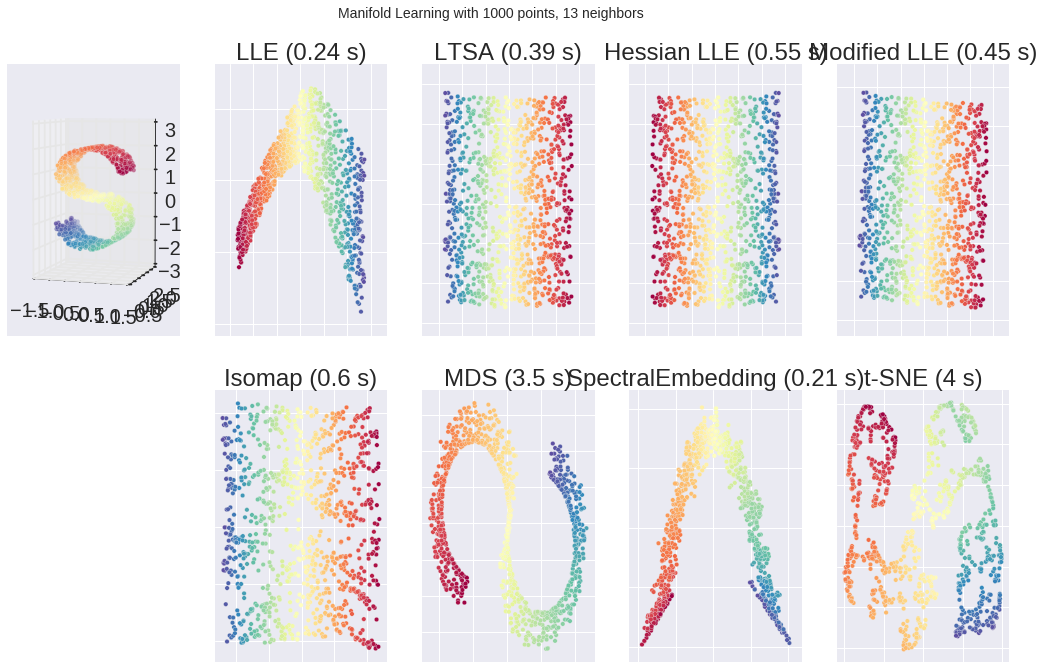

In [23]:
manifold_learning(n_neighbors=13)